In [1]:
# Ler os htmls da pasta e extrair valores com BeautifulSoup
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os

In [2]:
htmls = []
# Ler htmls criado pelo scraping.py da pasta /htmls/ e adicionar na lista htmls
for filename in os.listdir('C:\\Users\\lucas\\OneDrive\\Documentos\\Scripts python\\htmls'):
    if filename.endswith('.html'):
        with open(os.path.join('C:\\Users\\lucas\\OneDrive\\Documentos\\Scripts python\\htmls', filename), 'r', encoding='utf-8') as file:
            htmls.append(file.read())

In [3]:
htmls

['<!DOCTYPE html><html lang="pt-BR"><head>\n        <!--<script type="text/javascript">\n            window.dataLayer = window.dataLayer || [];\n        </script>-->\n        <!--<script type="text/javascript">\n            setTimeout(function () {\n                (function (w, d, s, l, i) {\n                    w[l] = w[l] || [];\n                    w[l].push({\n                        \'gtm.start\': new Date().getTime(), event: \'gtm.js\'\n                    });\n\n                    var f = d.getElementsByTagName(s)[0],\n                        j = d.createElement(s),\n                        dl = l !== \'dataLayer\' ? \'&l=\' + l : \'\';\n\n                    j.async = true;\n                    j.src = \'https://www.googletagmanager.com/gtm.js?id=\' + i + dl;\n\n                    f.parentNode.insertBefore(j, f);\n                })(window, document, \'script\', \'dataLayer\', \'GTM-54QGRMD\');\n            }, 3000);\n        </script>-->\n            <!-- Google tag (gtag.j

In [4]:
def extrair_dados_imovel(html_content):
    """
    Função para extrair dados de imóveis do HTML
    Retorna um dicionário com: localização, preço, valor_m2, área, quartos, vagas
    """
    soup = BeautifulSoup(html_content, 'html.parser')
    dados = {}
    
    # 1. Localização - extrair do h2
    localizacao_tag = soup.find('h2', class_='ellipse-text body-medium accent-color bold')
    dados['localizacao'] = localizacao_tag.text.strip() if localizacao_tag else None
    
    # 2. Preço - buscar na div imovel-price
    preco_div = soup.find('div', class_='imovel-price')
    if preco_div:
        # Buscar por h4 que contém "R$" mas não "Valor m²"
        h4_tags = preco_div.find_all('h4', class_='body-medium')
        for h4 in h4_tags:
            if h4.text and 'R$' in h4.text and 'Valor m²' not in h4.text:
                span = h4.find('span', class_='body-large bold')
                dados['preco'] = span.text.strip() if span else None
                break
        else:
            dados['preco'] = None
    else:
        dados['preco'] = None
    
    # 3. Valor por m² - buscar na div imovel-price
    if preco_div:
        h4_tags = preco_div.find_all('h4', class_='body-medium')
        for h4 in h4_tags:
            if h4.text and 'Valor m²' in h4.text:
                span = h4.find('span', class_='body-large bold')
                dados['valor_m2'] = span.text.strip() if span else None
                break
        else:
            dados['valor_m2'] = None
    else:
        dados['valor_m2'] = None
    
    # 4. Área - extrair do div com "m²"
    area_tag = soup.find('div', class_='border-1 py-0 px-2 bg-white body-small rounded-pill web-view')
    if area_tag and 'm²' in area_tag.text:
        dados['area'] = area_tag.text.strip()
    else:
        # Buscar em outros divs com m²
        area_divs = soup.find_all('div', class_='border-1 py-0 px-2 bg-white body-small rounded-pill')
        for div in area_divs:
            if 'm²' in div.text:
                dados['area'] = div.text.strip()
                break
        else:
            dados['area'] = None
    
    # 5. Quartos - extrair do div com "Quartos"
    quartos_divs = soup.find_all('div', class_='border-1 py-0 px-2 bg-white body-small rounded-pill')
    for div in quartos_divs:
        if 'Quartos' in div.text or 'Quarto' in div.text:
            dados['quartos'] = div.text.strip()
            break
    else:
        dados['quartos'] = None
    
    # 6. Vagas - extrair do div com "Vagas"
    for div in quartos_divs:  # Reutilizando a mesma busca
        if 'Vagas' in div.text or 'Vaga' in div.text:
            dados['vagas'] = div.text.strip()
            break
    else:
        dados['vagas'] = None
    
    return dados

In [5]:
dados_imoveis = []

# Processar cada HTML da lista htmls
for i, html_content in enumerate(htmls):
    print(f"Processando HTML {i+1} de {len(htmls)}...")
    soup = BeautifulSoup(html_content, 'html.parser')
    imoveis_sections = soup.find_all('h2', class_='ellipse-text body-medium accent-color bold')
    
    for j, imovel_section in enumerate(imoveis_sections):
        container = imovel_section.find_parent()
        
        while container and not container.find('div', class_='imovel-anunciante'):
            container = container.find_parent()
        
        if container:
            dados_imovel = extrair_dados_imovel(str(container))
            dados_imoveis.append(dados_imovel)
            print(f"  - HTML {i+1}: {dados_imovel['localizacao']}")

print(f"\nTotal de imóveis encontrados: {len(dados_imoveis)}")

df_imoveis = pd.DataFrame(dados_imoveis)

colunas_ordenadas = ['localizacao', 'preco', 'valor_m2', 'area', 'quartos', 'vagas']
df_imoveis = df_imoveis[colunas_ordenadas]

# Exibir informações do DataFrame
print(f"\nDataFrame criado com {len(df_imoveis)} imóveis e {len(df_imoveis.columns)} colunas")
print("\nPrimeiras 5 linhas:")
print(df_imoveis.head())

print("\nInformações gerais do DataFrame:")
print(df_imoveis.info())

Processando HTML 1 de 10...
  - HTML 1: SQNW 102 Bloco F NOROESTE, BRASILIA
  - HTML 1: SQN 303 Bloco I, ASA NORTE, BRASILIA
  - HTML 1: QS 5 Rua 400, AREAL, AGUAS CLARAS
  - HTML 1: SQSW 303 Bloco J, SUDOESTE, BRASILIA
  - HTML 1: Rua 24 NORTE, AGUAS CLARAS
  - HTML 1: SQN 402, ASA NORTE, BRASILIA
  - HTML 1: SQN 411, ASA NORTE, BRASILIA
  - HTML 1: Condomínio Residencial Santa Mônica, JARDIM BOTANICO, BRASILIA
  - HTML 1: CLNW 4/5 Lote E NOROESTE, BRASILIA
  - HTML 1: Avenida Parque Águas Claras, NORTE, AGUAS CLARAS
  - HTML 1: SQNW 307 Bloco A, NOROESTE, BRASILIA
  - HTML 1: Avenida das Araucárias, SUL, AGUAS CLARAS
  - HTML 1: SQNW 306 NOROESTE, BRASILIA
  - HTML 1: SQSW 500 Bloco H, SUDOESTE, BRASILIA
  - HTML 1: QI 31 Lotes 2/4, GUARA II, GUARA
  - HTML 1: Avenida Jacarandá, SUL, AGUAS CLARAS
  - HTML 1: SQSW 500 Bloco Q SUDOESTE, BRASILIA
  - HTML 1: SQN 211, ASA NORTE, BRASILIA
  - HTML 1: SQN 211, ASA NORTE, BRASILIA
  - HTML 1: QI 24, SETOR INDUSTRIAL, TAGUATINGA
  - HTML 1: 

In [6]:
# Visualizar o DataFrame completo
print("DataFrame completo:")
print(f"Shape: {df_imoveis.shape}")
print("\nTodas as colunas:")
print(df_imoveis.columns.tolist())

print("\nDados nulos por coluna:")
print(df_imoveis.isnull().sum())

print("\nExemplos de valores únicos:")
print(f"Localizações únicas: {df_imoveis['localizacao'].nunique()}")
print(f"Range de preços (apenas valores não-nulos): {df_imoveis['preco'].dropna().unique()[:10]}")
display(df_imoveis.head(10))

DataFrame completo:
Shape: (388, 6)

Todas as colunas:
['localizacao', 'preco', 'valor_m2', 'area', 'quartos', 'vagas']

Dados nulos por coluna:
localizacao      0
preco            0
valor_m2        88
area             1
quartos         96
vagas          116
dtype: int64

Exemplos de valores únicos:
Localizações únicas: 295
Range de preços (apenas valores não-nulos): ['Sob Consulta' '1.299.000' '539.000' '1.529.000' 'A partir de  637.750'
 '1.400.000' '1.090.000' '1.100.000' '900.000' '2.150.000']


,localizacao,preco,valor_m2,area,quartos,vagas
0,"SQNW 102 Bloco F NOROESTE, BRASILIA",Sob Consulta,None,127 m²,None,None
1,"SQN 303 Bloco I, ASA NORTE, BRASILIA",1.299.000,13.819,94 m²,3 Quartos,1 Vaga
2,"QS 5 Rua 400, AREAL, AGUAS CLARAS",539.000,8.983,60 m²,2 Quartos,1 Vaga
3,"SQSW 303 Bloco J, SUDOESTE, BRASILIA",1.529.000,19.329,79 m²,2 Quartos,1 Vaga
4,"Rua 24 NORTE, AGUAS CLARAS",A partir de 637.750,None,55 a 137 m²,None,None
5,"SQN 402, ASA NORTE, BRASILIA",1.400.000,9.929,141 m²,2 Quartos,2 Vagas
6,"SQN 411, ASA NORTE, BRASILIA",1.090.000,11.473,95 m²,3 Quartos,None
7,"Condomínio Residencial Santa Mônica, JARDIM BO...",1.100.000,4.583,240 m²,3 Quartos,2 Vagas
8,"CLNW 4/5 Lote E NOROESTE, BRASILIA",900.000,None,56 m²,None,None
9,"Avenida Parque Águas Claras, NORTE, AGUAS CLARAS",2.150.000,13.250,162 m²,3 Quartos,3 Vagas


In [7]:
# Remover todos os valores que não sejam números em 'preco' e 'valor_m2'
# Substituir strings vazias por NaN antes da conversão
df_imoveis['preco'] = df_imoveis['preco'].str.replace(r'[^\d]', '', regex=True)
df_imoveis['preco'] = df_imoveis['preco'].replace('', pd.NA)
df_imoveis['preco'] = pd.to_numeric(df_imoveis['preco'], errors='coerce')

df_imoveis['valor_m2'] = df_imoveis['valor_m2'].str.replace(r'[^\d]', '', regex=True)
df_imoveis['valor_m2'] = df_imoveis['valor_m2'].replace('', pd.NA)
df_imoveis['valor_m2'] = pd.to_numeric(df_imoveis['valor_m2'], errors='coerce')

# Remover tudo que não é número de area, quartos e vagas
df_imoveis['area'] = df_imoveis['area'].str.replace(r'[^\d]', '', regex=True)
df_imoveis['area'] = df_imoveis['area'].replace('', pd.NA)
df_imoveis['area'] = pd.to_numeric(df_imoveis['area'], errors='coerce')

df_imoveis['quartos'] = df_imoveis['quartos'].str.replace(r'[^\d]', '', regex=True)
df_imoveis['quartos'] = df_imoveis['quartos'].replace('', pd.NA)
df_imoveis['quartos'] = pd.to_numeric(df_imoveis['quartos'], errors='coerce')

df_imoveis['vagas'] = df_imoveis['vagas'].str.replace(r'[^\d]', '', regex=True)
df_imoveis['vagas'] = df_imoveis['vagas'].replace('', pd.NA)
df_imoveis['vagas'] = pd.to_numeric(df_imoveis['vagas'], errors='coerce')

# Remover linhas com valores nulos nas colunas importantes
df_imoveis.dropna(inplace=True)

df_imoveis

,localizacao,preco,valor_m2,area,quartos,vagas
1,"SQN 303 Bloco I, ASA NORTE, BRASILIA",1299000.0,13819.0,94.0,3.0,1.0
2,"QS 5 Rua 400, AREAL, AGUAS CLARAS",539000.0,8983.0,60.0,2.0,1.0
3,"SQSW 303 Bloco J, SUDOESTE, BRASILIA",1529000.0,19329.0,79.0,2.0,1.0
5,"SQN 402, ASA NORTE, BRASILIA",1400000.0,9929.0,141.0,2.0,2.0
7,"Condomínio Residencial Santa Mônica, JARDIM BO...",1100000.0,4583.0,240.0,3.0,2.0
...,...,...,...,...,...,...
382,"SHIN QI 12, LAGO NORTE, BRASILIA",3690000.0,3075.0,1200.0,6.0,8.0
383,"Quadra 104, NORTE, AGUAS CLARAS",2000000.0,12708.0,157.0,4.0,2.0
385,"RODOVIA BR 0020 KM 12,5, ALTO DA BOA VISTA, SO...",2250000.0,7352.0,306.0,4.0,2.0
386,"SGCV, PARK SUL, BRASILIA",410000.0,13666.0,30.0,1.0,1.0


In [8]:
# Separar endereço de bairro e cidade
df_imoveis[['endereco', 'bairro_cidade']] = df_imoveis['localizacao'].str.split(',', n=1, expand=True)

In [9]:
df_imoveis = df_imoveis.drop(columns=['localizacao'])
colunas_ordenadas = ['endereco', 'bairro_cidade', 'preco', 'valor_m2', 'area', 'quartos', 'vagas']
df_imoveis = df_imoveis[colunas_ordenadas]
df_imoveis.drop(columns=['valor_m2'], inplace=True) 

In [10]:
df_imoveis

,endereco,bairro_cidade,preco,area,quartos,vagas
1,SQN 303 Bloco I,"ASA NORTE, BRASILIA",1299000.0,94.0,3.0,1.0
2,QS 5 Rua 400,"AREAL, AGUAS CLARAS",539000.0,60.0,2.0,1.0
3,SQSW 303 Bloco J,"SUDOESTE, BRASILIA",1529000.0,79.0,2.0,1.0
5,SQN 402,"ASA NORTE, BRASILIA",1400000.0,141.0,2.0,2.0
7,Condomínio Residencial Santa Mônica,"JARDIM BOTANICO, BRASILIA",1100000.0,240.0,3.0,2.0
...,...,...,...,...,...,...
382,SHIN QI 12,"LAGO NORTE, BRASILIA",3690000.0,1200.0,6.0,8.0
383,Quadra 104,"NORTE, AGUAS CLARAS",2000000.0,157.0,4.0,2.0
385,RODOVIA BR 0020 KM 12,"5, ALTO DA BOA VISTA, SOBRADINHO",2250000.0,306.0,4.0,2.0
386,SGCV,"PARK SUL, BRASILIA",410000.0,30.0,1.0,1.0


array([[<Axes: title={'center': 'preco'}>,
        <Axes: title={'center': 'area'}>],
       [<Axes: title={'center': 'quartos'}>,
        <Axes: title={'center': 'vagas'}>]], dtype=object)

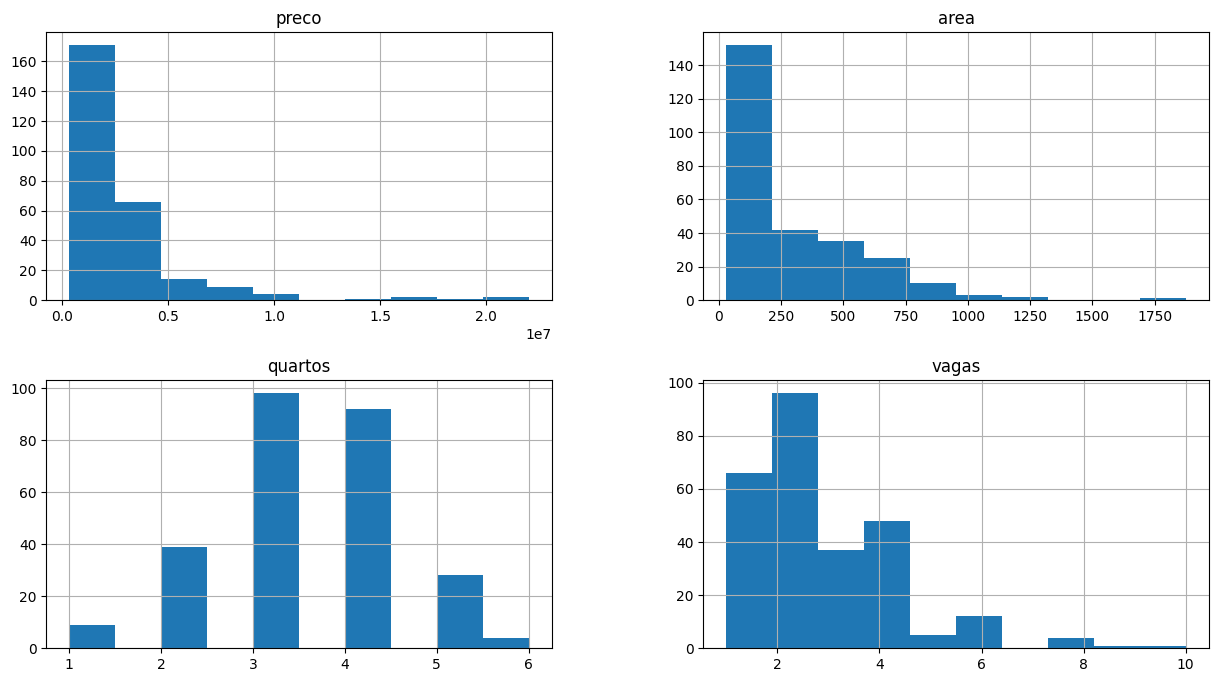

In [11]:
df_imoveis.hist(figsize=(15, 8))

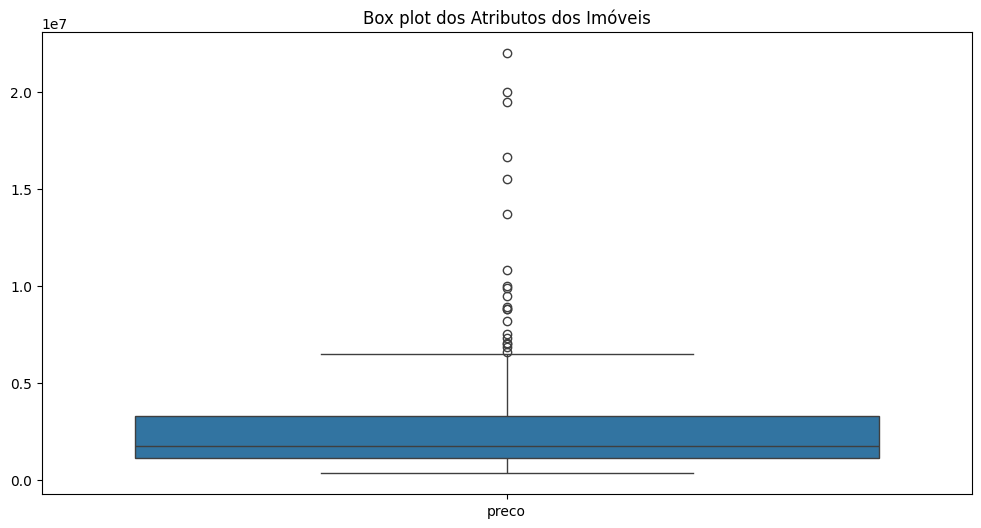

In [12]:
# Box plot para identificar outliers
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_imoveis[['preco']])
plt.title("Box plot dos Atributos dos Imóveis")
plt.show()


In [13]:
# Remover outliers de preco usando o método do IQR
Q1 = df_imoveis['preco'].quantile(0.25)
Q3 = df_imoveis['preco'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_imoveis = df_imoveis[(df_imoveis['preco'] >= lower_bound) & (df_imoveis['preco'] <= upper_bound)]

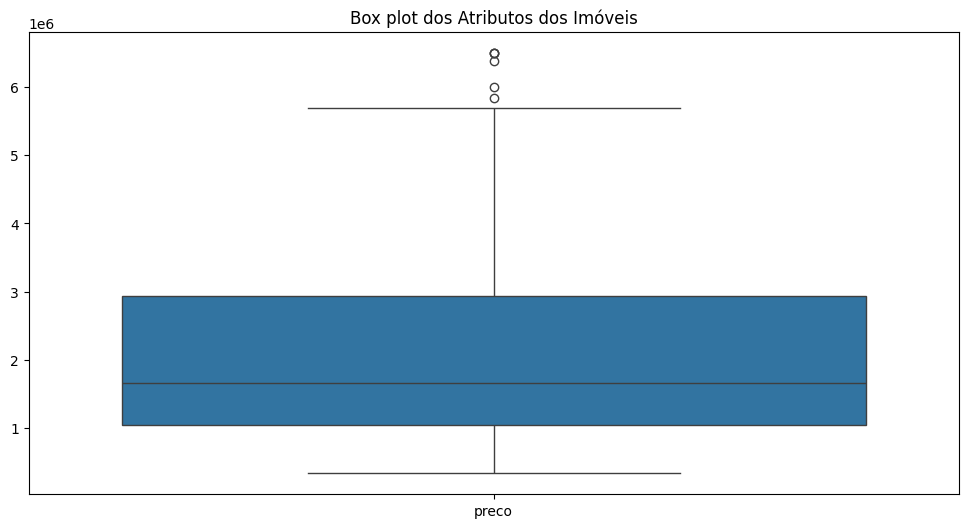

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_imoveis[['preco']])
plt.title("Box plot dos Atributos dos Imóveis")
plt.show()

In [15]:
# Aplica logaritmo na coluna preco para reduzir a assimetria
df_imoveis['preco'] = np.log(df_imoveis['preco'] + 1)
df_imoveis['area'] = np.log(df_imoveis['area'] + 1)

C:\Users\lucas\AppData\Local\Temp\ipykernel_7148\2435562558.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imoveis['preco'] = np.log(df_imoveis['preco'] + 1)
C:\Users\lucas\AppData\Local\Temp\ipykernel_7148\2435562558.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imoveis['area'] = np.log(df_imoveis['area'] + 1)


In [16]:
df_imoveis.to_csv('data/imoveis_tratados.csv', index=False)